# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [2]:
data = pd.read_csv('./datasets/raw_data/petfinder_raw.csv', compression='zip')
austin = pd.read_csv('./datasets/cleaned_data/austin.csv')

# Helper Functions

In [3]:
def quick_view(col):
    print(data[col].value_counts())
    print('')
    print(f'Missing Values: {data[col].isna().sum()}')
    print(f'Unique Entries: {len(data[col].value_counts())}')

# Inspect Data

In [4]:
data.shape

(74100, 50)

In [5]:
data.columns

Index(['id', 'organization_id', 'url', 'type', 'species', 'age', 'gender',
       'size', 'coat', 'tags', 'name', 'description', 'organization_animal_id',
       'photos', 'videos', 'status', 'status_changed_at', 'published_at',
       'distance', 'breeds.primary', 'breeds.secondary', 'breeds.mixed',
       'breeds.unknown', 'colors.primary', 'colors.secondary',
       'colors.tertiary', 'attributes.spayed_neutered',
       'attributes.house_trained', 'attributes.declawed',
       'attributes.special_needs', 'attributes.shots_current',
       'environment.children', 'environment.dogs', 'environment.cats',
       'primary_photo_cropped.small', 'primary_photo_cropped.medium',
       'primary_photo_cropped.large', 'primary_photo_cropped.full',
       'contact.email', 'contact.phone', 'contact.address.address1',
       'contact.address.address2', 'contact.address.city',
       'contact.address.state', 'contact.address.postcode',
       'contact.address.country', 'animal_id', 'animal_type',

## Feature Selection

Quick view of all the columns. Choose what columns to drop or keep

In [6]:
col = 'size'
quick_view(col)

Medium         35421
Large          26542
Small          11015
Extra Large     1122
Name: size, dtype: int64

Missing Values: 0
Unique Entries: 4


Drop data points that are not in Dallas / Austin datasets

In [7]:
# drop unused
data.drop(columns=['id', 'url', 'photos', 'type', 'species', 'coat', 'organization_id', 'organization_animal_id', 'status', 'status_changed_at',
                   'published_at', 'distance', 'breeds.unknown', 'colors.secondary', 'colors.tertiary',
                   'attributes.house_trained', 'attributes.declawed', 'attributes.shots_current',
                   'environment.children', 'environment.dogs', 'environment.cats', 'primary_photo_cropped.small', 
                   'primary_photo_cropped.medium', 'primary_photo_cropped.large', 'primary_photo_cropped.full',
                   'contact.email', 'contact.phone', 'contact.address.address1','contact.address.address2', 
                   'contact.address.city', 'contact.address.state', 'contact.address.postcode', 'contact.address.country',
                   'animal_id', 'animal_type', 'organization_id.1', 'primary_photo_cropped', 'videos'
                   ], inplace=True)

In [8]:
data.head(3)

,age,gender,size,tags,name,description,breeds.primary,breeds.secondary,breeds.mixed,colors.primary,attributes.spayed_neutered,attributes.special_needs
0,Adult,Male,Medium,"['Friendly', 'Smart', 'Funny', 'Playful']",Chip,"Hi, I&#039;m Chip! I traveled all the way from...",Labrador Retriever,NaN,True,Black,True,False
1,Baby,Female,Small,[],Clover D220199,You can fill out an adoption application onlin...,Terrier,NaN,True,NaN,True,False
2,Senior,Female,Small,[],Willow,"This sweet 8-yr old, 12 lb girl is such a litt...",Chihuahua,NaN,False,NaN,True,False


In [9]:
data.shape

(74100, 12)

## Feature cleaning

Impute ages

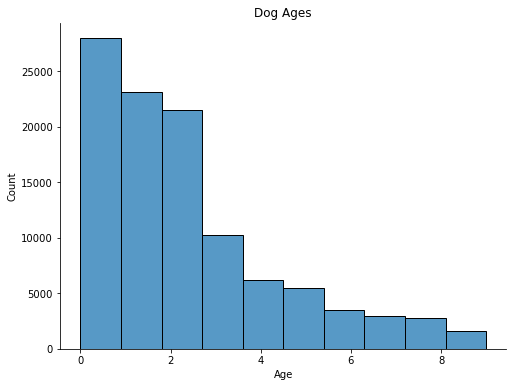

In [10]:
plt.figure(figsize=(8, 6))
plt.title('Dog Ages')
plt.xlabel('Age')
sns.histplot(data=austin[austin['age_out'] < 10], x='age_out', bins=10)
sns.despine()

Categorize the austin data age column according to the proportion of age categories in the petfinder data set

In [11]:
round(austin['age_out'], 0).value_counts(normalize=True).sort_index().cumsum()

0.0     0.186607
1.0     0.462298
2.0     0.656952
3.0     0.750102
4.0     0.806422
5.0     0.856098
6.0     0.887984
7.0     0.914899
8.0     0.939787
9.0     0.954589
10.0    0.971618
11.0    0.979431
12.0    0.987117
13.0    0.992142
14.0    0.995410
15.0    0.997818
16.0    0.998977
17.0    0.999475
18.0    0.999756
19.0    0.999937
20.0    0.999982
23.0    0.999991
24.0    1.000000
Name: age_out, dtype: float64

Proportions of dog ages from texas shelters dataset above\
\
Proportions of dog categories from petfinder dataset below

In [12]:
data['age'].value_counts(normalize=True).reindex(['Baby', 'Young', 'Adult', 'Senior']).cumsum()

Baby      0.203657
Young     0.489865
Adult     0.936613
Senior    1.000000
Name: age, dtype: float64

Dog age distributions line up nicely between the two data sets and pass the smell test. Texas shelter dogs between the ages of 0 & 0.5 years consisted of roughly 19% of the total dogs in the dataset. Petfinder dog age distribution has 20% of the dogs categorized as 'Baby'. This lines up nicely.\
\
Similarly with Young in petfinder at ~ 28% vs 27.6% of dogs age 1 in the Texas shelter data.\
\
Adult & Senior dogs will need a little more creativity to impute, but the below solution should also pass the smell test. Dog classifed as Adult in Petfinder consist of 45% of the population. Dogs age 2 - 8 in the Texas shelter data also consist of 45% of the population. A weighted average gives us an estimated age for petfinder dogs with the classification 'Adult' of 3.6 years. The same process is applied to Senior dogs, which the distributions suggest are ages 9 and up (passing the smell test). The dogs classified as Senior have a weighted average (from the Texas data ages) of 11 years of age.

In [13]:
# adult
ages_a = np.array(round(austin['age_out'], 0).value_counts(normalize=True).sort_index().loc[2:8].index) # get ages from index of dogs age 2-8
weights_a = np.array(round(austin['age_out'], 0).value_counts(normalize=True).sort_index().loc[2:8])    # get the percentage of dogs at each age
wei_sum_a = np.sum(weights_a)                                                                           # sum weights
wei_avg_a = round((np.sum(ages_a * weights_a)) / wei_sum_a, 2)                                          # calc weighted avg

# senior
ages_s = np.array(round(austin['age_out'], 0).value_counts(normalize=True).sort_index().loc[9:].index)  # get ages from index of dogs age 9 and above
weights_s = np.array(round(austin['age_out'], 0).value_counts(normalize=True).sort_index().loc[9:])     # get the percentage of dogs at each age
wei_sum_s = np.sum(weights_s)                                                                           # sum weights
wei_avg_s = round((np.sum(ages_s * weights_s)) / wei_sum_s, 2)                                          # calc weighted avg

mapper = {
            'Baby': 0,
            'Young': 1,
            'Adult': wei_avg_a,
            'Senior': wei_avg_s
            }
data['age_out'] = data['age'].map(mapper)                                                               # impute age in same format as austin & dallas shelter data

In [14]:
quick_view('gender')

Male      40142
Female    33958
Name: gender, dtype: int64

Missing Values: 0
Unique Entries: 2


In [15]:
# modify columns
data['gender'] = data['gender'].map({
    'Male': 1,
    'Female': 0
    })

In [16]:
# impute dog size from breed frame (WIP)

In [17]:
# will drop tags and description temporarily. Might revisit in the future if time permits. Too many missing values to easily extract signal from. But could be something there.
quick_view('tags')
data.drop(columns=['tags', 'description'], inplace=True)

[]                                                                                                                        51625
['Friendly', 'Affectionate', 'Playful']                                                                                     525
['Friendly', 'Playful']                                                                                                     334
['Friendly', 'Affectionate']                                                                                                247
['Friendly']                                                                                                                219
                                                                                                                          ...  
['Friendly', 'Affectionate', 'Playful', 'Smart', 'Brave', 'Curious', 'Loves kisses', 'Athletic', 'Funny']                     1
['Adventurous', 'Food Motivated', 'High Energy']                                                        

In [18]:
data['breeds.mixed'] = data['breeds.mixed'].map({
    True: 0,    # not a purebreed
    False: 1    # is a purebreed, not mixed
})
quick_view('breeds.mixed')

0    51308
1    22792
Name: breeds.mixed, dtype: int64

Missing Values: 0
Unique Entries: 2


In [19]:
# half of the dogs are missing a color value, but we might be able to impute dallas shelter dog color based on breed information from this list. 
quick_view('colors.primary')

Black                               10469
White / Cream                        5737
Brown / Chocolate                    4314
Yellow / Tan / Blond / Fawn          4161
Tricolor (Brown, Black, & White)     3379
Brindle                              2393
Gray / Blue / Silver                 1953
Red / Chestnut / Orange              1730
Bicolor                              1431
Apricot / Beige                      1194
Golden                                749
Merle (Blue)                          236
Sable                                 182
Merle (Red)                           115
Harlequin                              26
Name: colors.primary, dtype: int64

Missing Values: 36031
Unique Entries: 15


In [20]:
quick_view('attributes.spayed_neutered')
data['attributes.spayed_neutered'] = data['attributes.spayed_neutered'].map({
    True: 1,
    False: 0
    })

True     54287
False    19813
Name: attributes.spayed_neutered, dtype: int64

Missing Values: 0
Unique Entries: 2


In [21]:
quick_view('attributes.special_needs')
data['attributes.special_needs'] = data['attributes.special_needs'].map({
    True: 1,
    False: 0
    })

False    72017
True      2083
Name: attributes.special_needs, dtype: int64

Missing Values: 0
Unique Entries: 2


In [22]:
data.columns

Index(['age', 'gender', 'size', 'name', 'breeds.primary', 'breeds.secondary',
       'breeds.mixed', 'colors.primary', 'attributes.spayed_neutered',
       'attributes.special_needs', 'age_out'],
      dtype='object')

Rename columns

In [23]:
col_map = {
    'age': 'age',
    'gender': 'gender',
    'size': 'size',
    'name': 'name',
    'breeds.primary': 'breed_1',
    'breeds.secondary': 'breed_2',
    'breeds.mixed': 'purebreed',
    'breeds.unknown': 'mutt',
    'colors.primary': 'color',
    'attributes.spayed_neutered': 'intact_out',
    'attributes.special_needs': 'injured',
}
data.rename(columns=col_map, inplace=True)

In [24]:
data.head()

,age,gender,size,name,breed_1,breed_2,purebreed,color,intact_out,injured,age_out
0,Adult,1,Medium,Chip,Labrador Retriever,NaN,0,Black,1,0,3.60
1,Baby,0,Small,Clover D220199,Terrier,NaN,0,NaN,1,0,0.00
2,Senior,0,Small,Willow,Chihuahua,NaN,1,NaN,1,0,11.06
3,Adult,0,Small,Dolly,Yorkshire Terrier,Poodle,0,NaN,1,0,3.60
4,Young,0,Medium,Cheyenne,Terrier,NaN,0,Brown / Chocolate,1,0,1.00


# Data Export

In [25]:
data.to_csv('./datasets/cleaned_data/petfinder.csv', index=False)

# Edit color column - homogenize with texas shelters data

In [26]:
data.head()

,age,gender,size,name,breed_1,breed_2,purebreed,color,intact_out,injured,age_out
0,Adult,1,Medium,Chip,Labrador Retriever,NaN,0,Black,1,0,3.60
1,Baby,0,Small,Clover D220199,Terrier,NaN,0,NaN,1,0,0.00
2,Senior,0,Small,Willow,Chihuahua,NaN,1,NaN,1,0,11.06
3,Adult,0,Small,Dolly,Yorkshire Terrier,Poodle,0,NaN,1,0,3.60
4,Young,0,Medium,Cheyenne,Terrier,NaN,0,Brown / Chocolate,1,0,1.00


In [27]:
texas_shelters = pd.read_csv('/Users/annarutledge/Documents/general_assembly/project4/datasets/cleaned_data/texas_shelters.csv')

/Users/annarutledge/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,9,11,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
data['color'].unique()

array(['Black', nan, 'Brown / Chocolate', 'Brindle', 'White / Cream',
       'Yellow / Tan / Blond / Fawn', 'Red / Chestnut / Orange',
       'Gray / Blue / Silver', 'Golden',
       'Tricolor (Brown, Black, & White)', 'Apricot / Beige', 'Bicolor',
       'Merle (Blue)', 'Sable', 'Merle (Red)', 'Harlequin'], dtype=object)

In [29]:
data['color'].map(
    {
        'Black':['black, black'],
        'Brown / Chocolate':['brown, chocolate'],
        'Brindle':['brindle, brindle'],
        'White / Cream':['white, cream'],
        'Yellow / Tan / Blond / Fawn':['yellow, tan, blond, fawn'],
        'Red / Chestnut / Orange':['red, chestnut, orange'],
        'Gray / Blue / Silver':['gray, blue, silver'],
        'Golden':['golden, golden'],
        'Tricolor (Brown, Black, & White)':['tricolor, tricolor'],
        'Apricot / Beige':['apricot, beige'],
        'Bicolor':['bicolor, bicolor'],
        'Merle (Blue)':['merle, blue'],
        'Sable':['sable, sable'],
        'Merle (Red)':['merle, red'],
        'Harlequin':['harlequin, harlequin']
    }
)

0                    [black, black]
1                               NaN
2                               NaN
3                               NaN
4                [brown, chocolate]
                    ...            
74095          [tricolor, tricolor]
74096            [bicolor, bicolor]
74097                           NaN
74098    [yellow, tan, blond, fawn]
74099          [tricolor, tricolor]
Name: color, Length: 74100, dtype: object

In [30]:
texas_shelters['primary_color'].unique()

array(['Tricolor', 'Brown', 'Black', 'White', 'Tan', 'Gold', 'Sable',
       'Blue', 'Gray', 'Cream', 'Red', 'Yellow', 'Chocolate', 'Apricot',
       'Buff', 'Fawn', 'Silver', 'Liver', 'Orange', 'Ruddy', 'Agouti',
       'Calico', nan], dtype=object)

In [31]:
texas_shelters['secondary_color'].unique()

array(['Tricolor', 'White', 'Gray', 'Black', 'Tan', 'Gold', 'Merle',
       'Brown', 'Cream', 'Red', 'Yellow', 'Buff', 'Brindle', 'Blue',
       'Chocolate', 'Liver', 'Tick', 'Apricot', 'Sable', 'Silver',
       'Tiger', 'Fawn', 'Smoke', 'Orange', 'Pink', 'Agouti', 'Tortie',
       'Calico', nan], dtype=object)

In [32]:
# Edit colors to line up colors in texas_shelters

data['color'] = data['color'].map(
    {
        'Black':['black', 'black'], #
        'Brown / Chocolate':['brown', 'chocolate'], #
        'Brindle':['brindle', 'brindle'], #
        'White / Cream':['white', 'cream'], #
        'Yellow / Tan / Blond / Fawn':['yellow', 'tan'], #
        'Red / Chestnut / Orange':['red', 'orange'], #
        'Gray / Blue / Silver':['gray', 'blue'],
        'Golden':['gold', 'gold'], #
        'Tricolor (Brown, Black, & White)':['tricolor', 'tricolor'], #
        'Apricot / Beige':['apricot', 'buff'], #
        'Bicolor':['black', 'tan'], #
        'Merle (Blue)':['merle', 'blue'], #
        'Sable':['sable', 'sable'], #
        'Merle (Red)':['merle', 'red'], #
        'Harlequin':['white', 'black'] #
    }
)

In [33]:
data['color']

0              [black, black]
1                         NaN
2                         NaN
3                         NaN
4          [brown, chocolate]
                 ...         
74095    [tricolor, tricolor]
74096            [black, tan]
74097                     NaN
74098           [yellow, tan]
74099    [tricolor, tricolor]
Name: color, Length: 74100, dtype: object

In [34]:
primary_colors = []
secondary_colors = []

for i in range(len(data['color'])):
    if str(data['color'][i])!='nan':
        color_list = data['color'][i]
        print(i, color_list)
        primary_colors.append(color_list[0])
        secondary_colors.append(color_list[1])
    else:
        primary_colors.append(np.nan)
        secondary_colors.append(np.nan)
        print(i, 'nan')

0 ['black', 'black']
1 nan
2 nan
3 nan
4 ['brown', 'chocolate']
5 nan
6 ['brindle', 'brindle']
7 nan
8 nan
9 nan
10 nan
11 nan
12 nan
13 nan
14 ['brindle', 'brindle']
15 nan
16 ['brown', 'chocolate']
17 nan
18 ['brindle', 'brindle']
19 ['brindle', 'brindle']
20 ['black', 'black']
21 ['white', 'cream']
22 ['yellow', 'tan']
23 ['brindle', 'brindle']
24 ['white', 'cream']
25 ['brindle', 'brindle']
26 ['white', 'cream']
27 nan
28 ['black', 'black']
29 nan
30 ['black', 'black']
31 ['red', 'orange']
32 ['black', 'black']
33 nan
34 ['gray', 'blue']
35 nan
36 ['gray', 'blue']
37 ['black', 'black']
38 ['black', 'black']
39 ['black', 'black']
40 ['yellow', 'tan']
41 ['black', 'black']
42 ['white', 'cream']
43 ['yellow', 'tan']
44 ['white', 'cream']
45 ['white', 'cream']
46 ['brown', 'chocolate']
47 ['black', 'black']
48 ['black', 'black']
49 ['brown', 'chocolate']
50 ['yellow', 'tan']
51 ['brindle', 'brindle']
52 ['brown', 'chocolate']
53 ['black', 'black']
54 ['white', 'cream']
55 ['yellow', 't

In [35]:
data['primary_color'] = primary_colors

In [36]:
data['secondary_color'] = secondary_colors

In [37]:
data.head()

,age,gender,size,name,breed_1,breed_2,purebreed,color,intact_out,injured,age_out,primary_color,secondary_color
0,Adult,1,Medium,Chip,Labrador Retriever,NaN,0,"[black, black]",1,0,3.60,black,black
1,Baby,0,Small,Clover D220199,Terrier,NaN,0,NaN,1,0,0.00,NaN,NaN
2,Senior,0,Small,Willow,Chihuahua,NaN,1,NaN,1,0,11.06,NaN,NaN
3,Adult,0,Small,Dolly,Yorkshire Terrier,Poodle,0,NaN,1,0,3.60,NaN,NaN
4,Young,0,Medium,Cheyenne,Terrier,NaN,0,"[brown, chocolate]",1,0,1.00,brown,chocolate


In [38]:
data.to_csv('/Users/annarutledge/Documents/general_assembly/project4/datasets/cleaned_data/petfinder_colors_updated.csv')